In [1]:
%pip install numpy pandas scikit-learn folium geopandas shapely

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import geopandas
from shapely.geometry import Point
from datetime import datetime
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np
from folium.plugins import PolyLineTextPath
from geopy.distance import geodesic

In [3]:
# load
fpath = f'scrubbed.csv'
colnames = [
        'datetime',
        'city',
        'state',
        'country',
        'shape',
        'duration',
        'duration (hours/min)',
        'comments',
        'date posted',
        'latitude',
        'longitude',
        'empty'
    ]

with open(fpath,'r') as file:
    df = pd.read_csv(file, names=colnames, skiprows=1)

to_drop = [
    'empty', 
    'duration (hours/min)', 
    'date posted'
]
df.drop(labels=to_drop, axis=1, inplace = True)
df.head()

/tmp/ipykernel_28167/3047780995.py:19: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, names=colnames, skiprows=1)


,datetime,city,state,country,shape,duration,comments,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,This event took place in early fall around 194...,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1949 Lackland AFB&#44 TX. Lights racing acros...,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,Green/Orange circular disc over Chester&#44 En...,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,My older brother and twin sister were leaving ...,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.4180556,-157.803611


In [4]:
# data preparation

# fix datetime column, if not working otherwise
for row, cols in df.iterrows():
    if '24:00' in cols['datetime']:
        df.loc[row, 'datetime'] = cols['datetime'].replace('24:00', '00:00')

df['datetime'] = pd.to_datetime(df['datetime'])


In [5]:

#removing non-numeric columns from the data column longitude
# Convert the 'your_column' to numeric, setting errors='coerce' to turn non-numeric values into NaN
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop rows where 'your_column' is NaN
df = df.dropna(subset=['longitude'])

In [6]:
#removing non-numeric columns from the data column latitude
# Convert the 'your_column' to numeric, setting errors='coerce' to turn non-numeric values into NaN
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

# Drop rows where 'your_column' is NaN
df = df.dropna(subset=['latitude'])

In [7]:
# Check all columns for NAs
columns = [df[col].name for col in df.keys()]
columns

['datetime',
 'city',
 'state',
 'country',
 'shape',
 'duration',
 'comments',
 'latitude',
 'longitude']

In [8]:
def check_NA(dataframe: pd.DataFrame) -> None:
    NAs = [sum(df[col].isna()) for col in df[columns]]
    missing_values = zip(columns, NAs)
    print(dict([j for j in missing_values]))
    
check_NA(df)

{'datetime': 0, 'city': 0, 'state': 5797, 'country': 9669, 'shape': 1932, 'duration': 0, 'comments': 15, 'latitude': 0, 'longitude': 0}


In [9]:
# State can be empty, because there are datasets from other countries
vsel = df['state'].isna()
df.loc[vsel, 'state'] = 'None'

In [10]:
# Empty comments are ok
vsel = df['comments'].isna()
df.loc[vsel, 'comments'] = 'None'

In [11]:
# Empty shapes can be ok
vsel = df['shape'].isna()
df.loc[vsel, 'shape'] = 'None'

In [12]:
# Drop every other NA and check again
df.dropna(axis=0, inplace=True)
check_NA(df)
df.reset_index(drop=True, inplace=True)

{'datetime': 0, 'city': 0, 'state': 0, 'country': 0, 'shape': 0, 'duration': 0, 'comments': 0, 'latitude': 0, 'longitude': 0}


In [13]:
# augmentation of data with some possible explanations 
with open('Explanations.csv','r') as file:
    expl = pd.read_csv(file)

expl.head()


,shape,Explanation,Probability,Group together
0,cylinder,NaN,NaN,5.0
1,light,"Drone, Rocket",40%,NaN
2,circle,Satelite,60%,NaN
3,sphere,Starlink,50%,NaN
4,disk,Starlink,50%,NaN


In [14]:
df = pd.merge(df, expl, on='shape', how='left')

In [15]:
# check if everything looks ok
df.head()

,datetime,city,state,country,shape,duration,comments,latitude,longitude,Explanation,Probability,Group together
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,This event took place in early fall around 194...,29.883056,-97.941111,NaN,NaN,5.0
1,1955-10-10 17:00:00,chester (uk/england),None,gb,circle,20,Green/Orange circular disc over Chester&#44 En...,53.200000,-2.916667,Satelite,60%,NaN
2,1956-10-10 21:00:00,edna,tx,us,circle,20,My older brother and twin sister were leaving ...,28.978333,-96.645833,Satelite,60%,NaN
3,1960-10-10 20:00:00,kaneohe,hi,us,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.418056,-157.803611,"Drone, Rocket",40%,NaN
4,1961-10-10 19:00:00,bristol,tn,us,sphere,300,My father is now 89 my brother 52 the girl wit...,36.595000,-82.188889,Starlink,50%,NaN


In [16]:
# Check data points per year and state
df['year'] = df['datetime'].dt.year
country_year_counts = df.groupby(['country', 'year']).size().unstack(fill_value=0)

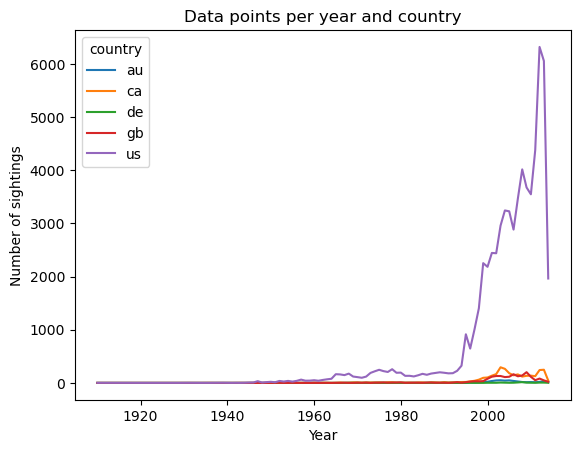

In [17]:
# Plot
country_year_counts.T.plot(kind='line', marker='')
plt.title('Data points per year and country')
plt.xlabel('Year')
plt.ylabel('Number of sightings')
plt.legend(title='country')
plt.show()

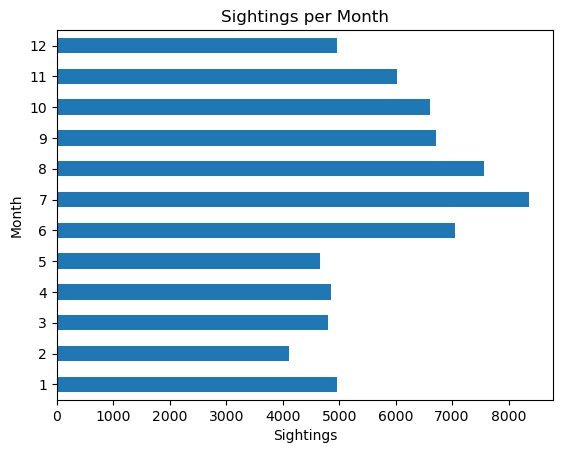

In [18]:
# In which months do we have the most sightings?
df['month'] = df['datetime'].dt.month
sightings_in_months = df.groupby(['month']).size()

# Plotten
sightings_in_months.plot(kind='barh')
plt.title('Sightings per Month')
plt.ylabel('Month')
plt.xlabel('Sightings')
plt.show()

In [19]:
# Create a map centered at the first data point. this map is created for the complete dataset and it is Huge!!
map_center = [df.iloc[0]['latitude'], df.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=14, tiles='Cartodb Positron')
# Add markers for each latitude and longitude point
for index, row in df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(m)

In [20]:
# Save the map to an HTML file. for the first 40 datapoints
m.save('map_mini.html')

In [21]:
# Assuming df is your original DataFrame
df_mini = df.iloc[:200]

In [22]:
# Select specific columns
selected_columns = ['datetime', 'latitude', 'longitude']
df_mini = df_mini[selected_columns]

In [23]:
# Extract features for clustering
df['timestamp'] = float
df['timestamp'] = df['datetime'].apply(lambda x: x.timestamp())
features = df[['latitude', 'longitude', 'timestamp']].values

In [24]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [25]:
# Perform DBSCAN clustering
db = DBSCAN(eps=0.3, min_samples=2, metric='euclidean')
df['cluster'] = db.fit_predict(features_scaled)

In [26]:
# Display the first few rows of the dataframe with cluster labels
print(df.head())
print(df['cluster'].unique())

             datetime                  city state country     shape duration  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder     2700   
1 1955-10-10 17:00:00  chester (uk/england)  None      gb    circle       20   
2 1956-10-10 21:00:00                  edna    tx      us    circle       20   
3 1960-10-10 20:00:00               kaneohe    hi      us     light      900   
4 1961-10-10 19:00:00               bristol    tn      us    sphere      300   

                                            comments   latitude   longitude  \
0  This event took place in early fall around 194...  29.883056  -97.941111   
1  Green/Orange circular disc over Chester&#44 En...  53.200000   -2.916667   
2  My older brother and twin sister were leaving ...  28.978333  -96.645833   
3  AS a Marine 1st Lt. flying an FJ4B fighter/att...  21.418056 -157.803611   
4  My father is now 89 my brother 52 the girl wit...  36.595000  -82.188889   

     Explanation Probability  Group together

In [27]:

# Create a map centered at the first data point
map_center = [df_mini.iloc[0]['latitude'], df_mini.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=10)

In [28]:
# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

In [56]:
# Add markers for each latitude and longitude point and having the timestamp visualize in the map as text
for index, row in df.iterrows():
    try:
        popup_text = f"Cluster: {row['cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")


In [57]:

# Save the map to an HTML file
m.save('clustered_f_mini.html')

In [30]:
#######with datetime weigthed heavier than Geo data

In [31]:
# Extract features for clustering
df_mini['timestamp'] = df_mini['datetime'].apply(lambda x: x.timestamp())

# Adjust the weight of the time component
time_weight = 100  # Adjust this factor to give more importance to the time component
df_mini['weighted_timestamp'] = df_mini['timestamp'] * time_weight

In [32]:
# Combine the features
features = df_mini[['latitude', 'longitude', 'weighted_timestamp']].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform DBSCAN clustering
db = DBSCAN(eps=0.3, min_samples=2, metric='euclidean')
df_mini['cluster'] = db.fit_predict(features_scaled)

In [33]:
# Create a map centered at the first data point
map_center = [df_mini.iloc[0]['latitude'], df_mini.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=10)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add markers for each latitude and longitude point
for index, row in df_mini.iterrows():
    try:
        popup_text = f"Cluster: {row['cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")

# Save the map to an HTML file
m.save('clustered_map_mini_weighted.html')

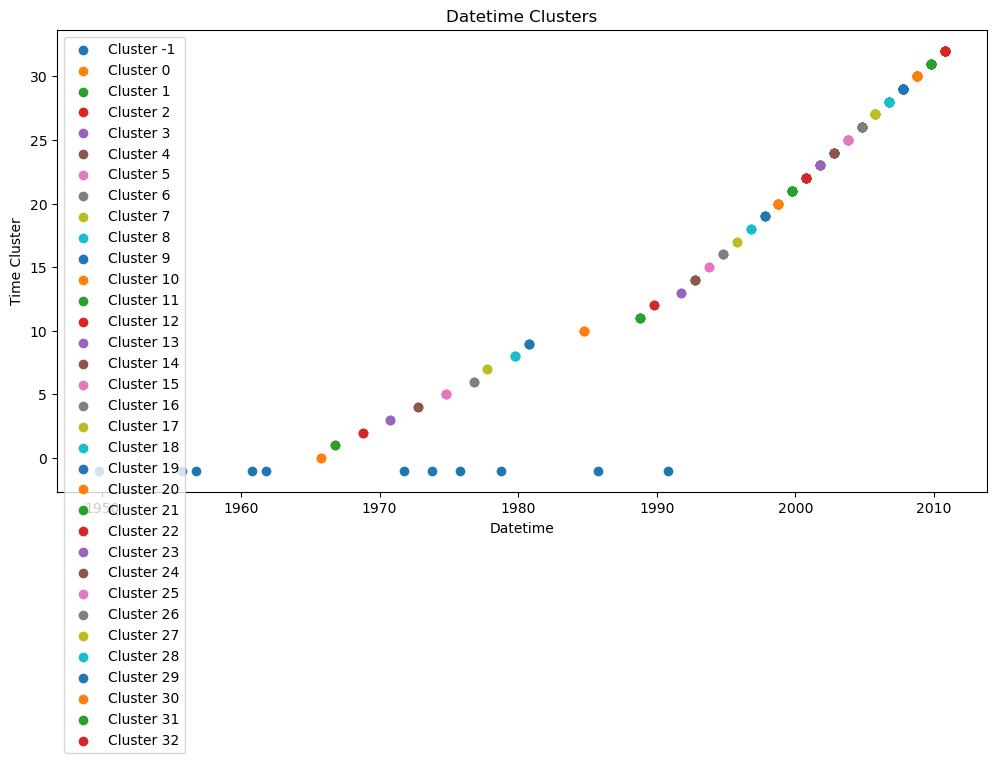

In [34]:
#Step 1
# Extract timestamp for clustering
df_mini['timestamp'] = df_mini['datetime'].apply(lambda x: x.timestamp())
time_features = df_mini[['timestamp']].values

# Standardize the time features
scaler = StandardScaler()
time_features_scaled = scaler.fit_transform(time_features)

# Perform DBSCAN clustering on time features
time_db = DBSCAN(eps=0.01, min_samples=2, metric='euclidean')
df_mini['time_cluster'] = time_db.fit_predict(time_features_scaled)

# Visualize datetime clusters
plt.figure(figsize=(12, 6))
for cluster in df_mini['time_cluster'].unique():
    cluster_data = df_mini[df_mini['time_cluster'] == cluster]
    plt.scatter(cluster_data['datetime'], cluster_data['time_cluster'], label=f'Cluster {cluster}')
plt.xlabel('Datetime')
plt.ylabel('Time Cluster')
plt.title('Datetime Clusters')
plt.legend()
plt.show()

In [35]:
#Step 2


In [36]:
# Function to perform geo clustering within each time cluster
def geo_clustering(df_mini, eps=0.3, min_samples=2):
    geo_clusters = []
    for cluster in df_mini['time_cluster'].unique():
        if cluster == -1:  # Skip noise points
            continue
        cluster_data = df_mini[df_mini['time_cluster'] == cluster].copy()
        geo_features = cluster_data[['latitude', 'longitude']].values
        geo_features_scaled = scaler.fit_transform(geo_features)
        geo_db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        cluster_data.loc[:, 'geo_cluster'] = geo_db.fit_predict(geo_features_scaled)
        geo_clusters.append(cluster_data)
    return pd.concat(geo_clusters)

In [37]:
# Perform geo clustering
df_mini2 = geo_clustering(df_mini)

In [38]:

# Create a map centered at the first data point
map_center = [df_mini2.iloc[0]['latitude'], df_mini2.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=5)

In [39]:
# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add markers for each latitude and longitude point
#colors based on time clusters and not Geo clusters, as we only have one geo cluster per time cluster.
for index, row in df_mini2.iterrows():
    try:
        popup_text = f"Time Cluster: {row['time_cluster']}<br>Geo Cluster: {row['geo_cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['time_cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")

# Save the map to an HTML file
m.save('clustered_map_mini_2step.html')

In [40]:
####finding the Ailien bases

In [41]:
# Find the point closest to the centroid within each geo cluster
def find_closest_to_centroid(df_mini2):
    closest_points = []
    for time_cluster in df_mini2['time_cluster'].unique():
        if time_cluster == -1:
            continue
        time_cluster_data = df_mini2[df_mini2['time_cluster'] == time_cluster]
        for geo_cluster in time_cluster_data['geo_cluster'].unique():
            if geo_cluster == -1:
                continue
            geo_cluster_data = time_cluster_data[time_cluster_data['geo_cluster'] == geo_cluster]
            centroid = geo_cluster_data[['latitude', 'longitude']].mean().values
            distances = cdist([centroid], geo_cluster_data[['latitude', 'longitude']].values)
            closest_index = distances.argmin()
            closest_points.append(geo_cluster_data.iloc[closest_index])
    return pd.DataFrame(closest_points)

In [42]:
# Get the closest points to centroids
closest_points_df_mini2 = find_closest_to_centroid(df_mini2)


In [43]:

# Create a map centered at the first data point
map_center = [df_mini2.iloc[0]['latitude'], df_mini2.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=1)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add markers for each latitude and longitude point, colored by time cluster
for index, row in df_mini2.iterrows():
    try:
        popup_text = f"Time Cluster: {row['time_cluster']}<br>Geo Cluster: {row['geo_cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['geo_cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")

# Add markers for the closest points to centroids
for index, row in closest_points_df_mini2.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Closest to Centroid<br>Time Cluster: {row['time_cluster']}<br>Geo Cluster: {row['geo_cluster']}<br>Datetime: {row['datetime']}",
        icon=folium.Icon(color='black', icon='star')
    ).add_to(m)

# Save the map to an HTML file
m.save('Ailien bases.html')

In [44]:
####moving path 

In [45]:
# Add lines to represent the most probable moving paths
# Create a map centered at the first data point
map_center = [df_mini2.iloc[0]['latitude'], df_mini2.iloc[0]['longitude']]
m = folium.Map(location=map_center, zoom_start=4)

# Add markers for each latitude and longitude point, colored by time cluster
for index, row in df_mini2.iterrows():
    try:
        popup_text = f"Time Cluster: {row['time_cluster']}<br>Geo Cluster: {row['geo_cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['geo_cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add lines to represent the most probable moving paths
# Add lines with directional arrows to represent the most probable moving paths
for time_cluster in df_mini2['time_cluster'].unique():
    if time_cluster == -1:
        continue
    time_cluster_data = df_mini2[df_mini2['time_cluster'] == time_cluster]
    for geo_cluster in time_cluster_data['geo_cluster'].unique():
        if geo_cluster == -1:
            continue
        geo_cluster_data = time_cluster_data[time_cluster_data['geo_cluster'] == geo_cluster]
        geo_cluster_data = geo_cluster_data.sort_values(by='datetime')
        path = geo_cluster_data[['latitude', 'longitude']].values.tolist()
        polyline = folium.PolyLine(path, color='blue', weight=2.5, opacity=0.7)
        polyline.add_to(m)
        # Add directional arrows
        arrows = PolyLineTextPath(polyline, '→', repeat=True, offset=7, attributes={'fill': 'blue'})
        arrows.add_to(m)


# Save the map to an HTML file
m.save('moving_paths_mini.html')

In [46]:
####claculate speed
##Issue: it does not go through all the objects in one geo- & time cluster


In [47]:
# Calculate speed for each object within each geo-time cluster
def calculate_speed(df_mini2):
    speeds = []
    for time_cluster in df_mini2['time_cluster'].unique():
        if time_cluster == -1:
            continue
        time_cluster_data = df_mini2[df_mini2['time_cluster'] == time_cluster]
        for geo_cluster in time_cluster_data['geo_cluster'].unique():
            if geo_cluster == -1:
                continue
            geo_cluster_data = time_cluster_data[time_cluster_data['geo_cluster'] == geo_cluster]
            geo_cluster_data = geo_cluster_data.sort_values(by='datetime')
            for i in range(1, len(geo_cluster_data)):
                point1 = geo_cluster_data.iloc[i - 1]
                point2 = geo_cluster_data.iloc[i]
                distance = geodesic((point1['latitude'], point1['longitude']), (point2['latitude'], point2['longitude'])).meters
                time_diff = (point2['datetime'] - point1['datetime']).total_seconds()
                speed = distance / time_diff if time_diff > 0 else 0
                speeds.append({
                    'datetime': point2['datetime'],
                    'latitude': point2['latitude'],
                    'longitude': point2['longitude'],
                    'speed': speed,
                    'geo_cluster': point2['geo_cluster'],
                    'time_cluster': point2['time_cluster']
                })
    return pd.DataFrame(speeds)

# Get the speeds DataFrame
speeds_df_mini2 = calculate_speed(df_mini2)

# Save the speeds DataFrame to a CSV file
speeds_df_mini2.to_csv('speeds.csv', index=False)


In [48]:
speeds_df_mini2

,datetime,latitude,longitude,speed,geo_cluster,time_cluster
0,1998-10-10 17:30:00,36.175000,-115.136389,0.000000,0,20
1,1998-10-10 23:50:00,35.265000,-84.553333,31.643119,1,20
2,1999-10-10 20:35:00,37.668889,-122.079722,0.529329,0,21
3,1999-10-10 22:30:00,45.565000,-117.916389,3.357229,1,21
4,2000-10-10 20:30:00,38.126667,-92.084444,3.182746,0,22
5,2000-10-10 22:00:00,47.540556,-122.635000,13.348344,1,22
6,2001-10-10 21:15:00,41.004167,-92.373611,3.705040,0,23
7,2001-10-10 23:00:00,36.852778,-75.978333,236.796394,0,23
8,2001-10-10 21:30:00,36.747778,-119.771389,69.388263,1,23
9,2001-10-10 22:00:00,33.448333,-112.073333,439.582605,1,23


In [49]:
# Save the map to an HTML file. takes over 20min to open and does not properly work due to my laptop dying
m.save('map.html')

In [50]:
# Assuming df is your original DataFrame
df_mini = df.iloc[:1000]

In [51]:
# Create a map centered at the first data point. this map is created for the first 40 datapoints
map_center = [df_mini.iloc[0]['latitude'], df_mini.iloc[0]['longitude']]
n = folium.Map(location=map_center, zoom_start=10)
# Add markers for each latitude and longitude point
for index, row in df_mini.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(n)

In [52]:
df_mini2.head()

,datetime,latitude,longitude,timestamp,weighted_timestamp,cluster,time_cluster,geo_cluster
5,1965-10-10 21:00:00,51.434722,-3.180000,-133326000.0,-1.333260e+10,-1,0,-1
6,1965-10-10 23:45:00,41.117500,-73.408333,-133316100.0,-1.333161e+10,-1,0,-1
7,1966-10-10 20:00:00,33.586111,-86.286111,-101793600.0,-1.017936e+10,0,1,-1
8,1966-10-10 21:00:00,30.294722,-82.984167,-101790000.0,-1.017900e+10,-1,1,-1
9,1968-10-10 13:00:00,33.916389,-118.351667,-38660400.0,-3.866040e+09,-1,2,-1


In [53]:
# Add lines to represent the most probable moving paths
# Create a map centered at the first data point
map_center = [41, -88]
zoom = 7
m = folium.Map(location=map_center, zoom_start=zoom)

# Add markers for each latitude and longitude point, colored by time cluster
for index, row in df_mini2.iterrows():
    try:
        popup_text = f"Time Cluster: {row['time_cluster']}<br>Geo Cluster: {row['geo_cluster']}<br>Datetime: {row['datetime']}"
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup_text,
            icon=folium.Icon(color=colors[row['geo_cluster'] % len(colors)])
        ).add_to(m)
    except ValueError:
        print(f"Skipping invalid data at index {index}")

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add lines to represent the most probable moving paths
# Add lines with directional arrows to represent the most probable moving paths
for time_cluster in df_mini2['time_cluster'].unique():
    if time_cluster == -1:
        continue
    time_cluster_data = df_mini2[df_mini2['time_cluster'] == time_cluster]
    for geo_cluster in time_cluster_data['geo_cluster'].unique():
        if geo_cluster == -1:
            continue
        geo_cluster_data = time_cluster_data[time_cluster_data['geo_cluster'] == geo_cluster]
        geo_cluster_data = geo_cluster_data.sort_values(by='datetime')
        path = geo_cluster_data[['latitude', 'longitude']].values.tolist()
        polyline = folium.PolyLine(path, color='blue', weight=2.5, opacity=0.7)
        polyline.add_to(m)
        # Add directional arrows
        arrows = PolyLineTextPath(polyline, '→', repeat=True, offset=7, attributes={'fill': 'blue'})
        arrows.add_to(m)

# Add center point of each geocluster to df
df_mini2['centers'] = list
centers = {}
for gc in df_mini2['geo_cluster'].unique():
    vsel = df_mini2['geo_cluster'] == gc
    selection = df_mini2[vsel]
    center = [np.mean(selection['latitude']), np.mean(selection['longitude'])]
    centers[gc] = center
df_mini2['centers'] = df_mini2['geo_cluster'].map(centers)

# Add distance of each point to center
df_mini2['dist'] = float
for row,cols in df_mini2.iterrows():
    a = cols['latitude']
    b = cols['longitude']
    x = cols['centers'][0]
    y = cols['centers'][1]
    df_mini2.loc[row, 'dist'] = ((a-x)**2 + (b-y)**2)**0.5

# Calculate mean distance to center of each cluster
df_mini2['shape']= float
shapes = {}
for gc in df_mini2['geo_cluster'].unique():
    vsel = df_mini2['geo_cluster'] == gc
    selection = df_mini2[vsel]
    shape = np.mean(selection['dist'])
    shapes[gc] = shape
df_mini2['shape'] = df_mini2['geo_cluster'].map(shapes)

In [54]:
df_mini2[df_mini2['geo_cluster'] != -1]

,datetime,latitude,longitude,timestamp,weighted_timestamp,cluster,time_cluster,geo_cluster,centers,dist,shape
66,1998-10-10 17:30:00,36.175000,-115.136389,9.080406e+08,9.080406e+10,9,20,0,"[39.286966668, -92.28687777200003]",23.060453,14.165554
67,1998-10-10 17:30:00,36.175000,-115.136389,9.080406e+08,9.080406e+10,9,20,0,"[39.286966668, -92.28687777200003]",23.060453,14.165554
69,1998-10-10 20:50:00,35.584722,-80.810278,9.080526e+08,9.080526e+10,12,20,1,"[39.26973545714285, -111.6136111095238]",31.02297,11.763488
71,1998-10-10 23:50:00,35.265000,-84.553333,9.080634e+08,9.080634e+10,12,20,1,"[39.26973545714285, -111.6136111095238]",27.355009,11.763488
72,1999-10-10 00:01:00,38.019444,-122.133056,9.395137e+08,9.395137e+10,9,21,0,"[39.286966668, -92.28687777200003]",29.873081,14.165554
76,1999-10-10 12:40:00,46.211389,-119.136111,9.395592e+08,9.395592e+10,11,21,1,"[39.26973545714285, -111.6136111095238]",10.235944,11.763488
77,1999-10-10 20:35:00,37.668889,-122.079722,9.395877e+08,9.395877e+10,9,21,0,"[39.286966668, -92.28687777200003]",29.836752,14.165554
80,1999-10-10 22:30:00,45.565000,-117.916389,9.395946e+08,9.395946e+10,11,21,1,"[39.26973545714285, -111.6136111095238]",8.908163,11.763488
82,2000-10-10 03:00:00,37.724167,-89.861111,9.711468e+08,9.711468e+10,9,22,0,"[39.286966668, -92.28687777200003]",2.8856,14.165554
85,2000-10-10 20:30:00,38.126667,-92.084444,9.712098e+08,9.712098e+10,9,22,0,"[39.286966668, -92.28687777200003]",1.177827,14.165554


In [55]:
print('Distances in km: ')
[i*111 for i in df_mini2['shape'].unique()]

Distances in km: 


[2287.3000201913933,
 1572.3765476399992,
 1305.747173560169,
 1111.3983056598383,
 523.0000462645796]